In [2]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
import time
from datetime import timedelta, date, datetime

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [5]:
#read dataframe from DB

df=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst = True)
df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True)

df = df.loc['2017-01-01':'2020-12-31']
df2 = df2.loc['2017-01-01':'2020-12-31']

columns = ['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns : 
    df[column] = df2[column].resample("D").mean()

columns = ['Electricity Consumption (MWh)']
for column in columns : 
    df[column] = df2[column].resample("D").sum()
    
df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [6]:
df_u=df['Price - PT [€/MWh]'].dropna()

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_u)#, autolag= 'AIC'

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.479779
p-value: 0.120472
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [8]:
df_u = df_u.diff().dropna()

In [9]:
result = adfuller(df_u)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.010834
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [10]:
# split into train and test sets # revoir avec le pourcentage 0,66
size = int(len(df_u) * 0.8)
train, test = df_u[0:size], df_u[size:len(df_u)]

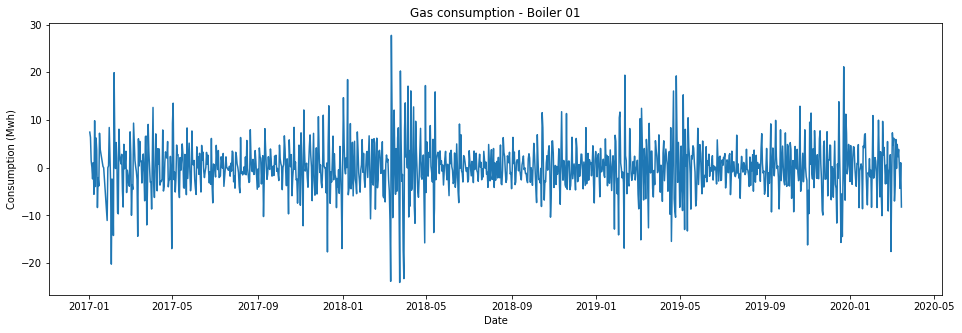

In [11]:
plt.figure(figsize=(16,5))
plt.gca().set(title='Gas consumption - Boiler 01', xlabel='Date', ylabel='Consumption (Mwh)')
plt.plot(train.index, train) 
plt.show()

In [12]:
#Grid search to find ARIMA params (p, d, q)
import warnings # supress warnings
warnings.filterwarnings('ignore')
import itertools
#set parameter range
p = range(0,7)
q = range(0,3)
d = range(0,3)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
print(pdq)

#ARIMA model pipeline
tab_param=[]
tab_aic=[]
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(train,order=param)
        results = mod.fit()
        print(result)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        pass

    tab_param.append(param)
    tab_aic.append(results.aic)

param_tunning_df= pd.DataFrame({'param': tab_param, 'aic':tab_aic })

param_tunning_df.loc[param_tunning_df['aic'].idxmin()]['param']

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2), (6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 2, 0), (6, 2, 1), (6, 2, 2)]
(-11.010833851444282, 6.331656054994642e-20, 20, 1432, {'1%': -3.4349247631306237, '5%': -2.8635604442944658, '10%': -2.5678456715029183}, 8438.795499742371)
ARIMA(0, 0, 0) - AIC:7181.4515187030065
(-11.010833851444282, 6.331656054994642e-20, 20, 1432, {'1%': -3.4349247631306237, '5%': -2.8635604442944658

(6, 0, 2)

In [13]:
df.columns

Index(['Price - PT [€/MWh]', 'Price - ES [€/MWh]', 'Actual Consumption (MWh)',
       'Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC',
       'Hydro Pumped Storage AA', 'Hydro Pumped Storage AC',
       'Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA',
       'Other AA', 'Solar AA', 'Wind Onshore AA',
       'Electricity Consumption (MWh)'],
      dtype='object')

In [14]:
#rename the Price column into 'PricePT'
df.columns = ['PricePT', 'Price - ES [€/MWh]', 'Actual Consumption (MWh)','Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)']

In [15]:
#daily 6, 0, 2
from statsmodels.tsa.arima.model import ARIMA

X = df.PricePT.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

start_time = time.time()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(6,0,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# evaluate forecasts

exec_time = time.time() - start_time

In [16]:
print('Mean Squared Error:', metrics.mean_squared_error(test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test, predictions)))
print('Mean Absolute Error:', metrics.mean_absolute_error(test, predictions))
print('Coefficient of Variance:', (np.sqrt(metrics.mean_squared_error(test, predictions))/test.mean())*100)
print('Execution Time:', '%.5f' %  exec_time)

Mean Squared Error: 27.385590360421418
Root Mean Squared Error: 5.233124340240868
Mean Absolute Error: 3.962244345398556
Coefficient of Variance: 14.552009198678393
Execution Time: 2102.93149
